# Introduction

In this chapter we will start to perform analysis for all cities rather than just one. Say for example counting the number of museums for each city. In the process we will learn some Advanced Spark Dataframe concepts.

## Advanced Dataframe API

Most of the time in Spark SQL you can use Strings (in SQL) to reference columns but there are two cases where  you’ll want to use the Column objects rather than Strings :

* In Spark SQL DataFrame columns are allowed to have the same name, they’ll be given unique names inside of Spark SQL, but this means that you can’t reference them with the column name only as this becomes ambiguous.

* When you need to manipulate columns using expressions like Adding two columns to each other, Twice the value of this column or even "Is the column value larger than 0?", you won’t be able to use simple strings and will need the Column reference.

* Finally if you need renaming, cast or any other complex feature, you’ll need the Column reference too.


# Joins, UDFs, Broadcast Variables, Spatial Predicate

## Joins
Joining data is an important part of many of our pipelines, and both Spark core and Spark SQL support the same fundamental types of joins. While joins are very common and powerful, they warrant special performance consideration as they may require large network transfers or even create data sets beyond our capability to handle. In core Spark it can be more important to think about the ordering of operations, since the DAG optimizer, unlike the SQL optimizer isn’t able to re-order or push down filters.

## User-Defined Functions (aka UDF)

User-Defined Functions (aka UDF) is a feature of Spark SQL to define new Column-based functions that extend the vocabulary of Spark SQL’s DSL to transform Datasets.

## Broadcast variables 

Broadcast variables allow the programmer to keep a read-only variable cached on each machine rather than shipping a copy of it with tasks. Explicitly creating broadcast variables is only useful when tasks across multiple stages need the same data or when caching the data in deserialized form is important.

## Exercise: for each city count the number of museums

In this Exercise for each city we will count the number of museums and return a Dataframe with: city_name, museum_count

In [1]:
# %load './code/helpers/imports.py'
import notebook
import os.path, json, io, pandas
import matplotlib.pyplot as plt

%pylab inline
pylab.rcParams['figure.figsize'] = (54, 60)


from retrying import retry # for exponential back down when calling TurboOverdrive API

import pyspark.sql.functions as func # resuse as func.coalace for example
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType,DecimalType

import pandas as pandas
from geopandas import GeoDataFrame # Loading boundaries Data
from shapely.geometry import Point, Polygon, shape # creating geospatial data
from shapely import wkb, wkt # creating and parsing geospatial data
import overpy # OpenStreetMap API

from ast import literal_eval as make_tuple # used to decode data from java

# make sure nbextensions are installed
notebook.nbextensions.check_nbextension('usability/codefolding', user=True)

try:
    sc
except NameError:
    import pyspark
    sc = pyspark.SparkContext('local[*]')
    sqlContext = pyspark.sql.SQLContext(sc)


Populating the interactive namespace from numpy and matplotlib


In [2]:
# %load './code/helpers/load_boundaries_and_pois.py'
OVERPASS_API         = overpy.Overpass()
BASE_DIR             = os.path.join(os.path.abspath('.'), 'work-flow')
URBAN_BOUNDARIES_FILE = '06_Europe_Cities_Boundaries_with_Labels_Population.geo.json'

# Paths to base datasets that we are using:
URBAN_BOUNDARIES_PATH = os.path.join(BASE_DIR,URBAN_BOUNDARIES_FILE)
POIS_PATH            = os.path.join(BASE_DIR, "pois.json")

try:
    geo_df
except NameError:
    geo_df = GeoDataFrame.from_file(URBAN_BOUNDARIES_PATH)
    # Add a WKT column for use later
    geo_df['wkt'] = pandas.Series(
        map(lambda geom: str(geom.to_wkt()), geo_df['geometry']),
        index=geo_df.index, dtype='string')

try:
    boundaries_from_pd
except NameError:
    boundaries_from_pd = sqlContext.createDataFrame(geo_df)
    boundaries_from_pd.registerTempTable("boundaries")

try:
    pois_df
except NameError:
    pois_df = sqlContext.read.json(POIS_PATH)
    pois_df = pois_df.toPandas()
    def toWktColumn(coords):
        return (Point(coords).wkt)

    pois_df['wkt'] = pandas.Series(
        map(lambda geom: toWktColumn(geom.coordinates), pois_df['geometry']),
        index=pois_df.index, dtype='string')

    pois_df = sqlContext.createDataFrame(pois_df)


In [13]:
# -------------------------------------- Solution below -------------------------------------- #

# Hint: We want to do a join based on within spatial predicate (from shapely)
# Hint: Get a dataframe with city name and city geometry
# Hint: when you have the join perform a group by

# Some Useful references to documentation
# # http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.join
# # http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.SQLContext.registerFunction
# # http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.udf
# # http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.Column.cast


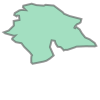

In [3]:
# Exercise
# for each city count the number of museums
# and return a DF with:
# city_name, museum_count

# SQL Version
# cities_df = sqlContext.sql(
#     """
#     SELECT properties.NAMEASCII AS city_name, 
#         geometry AS city_geom FROM boundaries
#     """)

cities_df = boundaries_from_pd.select(
    (boundaries_from_pd.NAMEASCII).alias('city_name'),
    (boundaries_from_pd.wkt).alias('city_geom'))

cities_df.cache()

# Create a broadcast variable
# Broadcast http://spark.apache.org/docs/latest/programming-guide.html#broadcast-variables
# Broadcast variables allow the programmer to keep a read-only variable cached on each machine 
# rather than shipping a copy of it with tasks. They can be used, for example, to give every node 
# a copy of a large input dataset in an efficient manner. Spark also attempts to distribute broadcast
# variables using efficient broadcast algorithms to reduce communication cost.

# Spark actions are executed through a set of stages, separated by distributed “shuffle” 
# operations. Spark automatically broadcasts the common data needed by tasks within each stage. 
# The data broadcasted this way is cached in serialized form and deserialized before running each task. 
# This means that explicitly creating broadcast variables is only useful when tasks across multiple 
# stages need the same data or when caching the data in deserialized form is important.

# Broadcast variables are created from a variable v by calling SparkContext.broadcast(v). The broadcast 
# variable is a wrapper around v, and its value can be accessed by calling the value method.

_cities_df = cities_df.toJSON().collect()[0:3]
broadcastCitiesJSON = sc.broadcast(_cities_df)

wkt.loads(json.loads(broadcastCitiesJSON.value[0])['city_geom'])

In [6]:
def get_city_name(poi_geom):
    # get an array of dict [(city_name, city_geom)]
    cities = map(lambda c: {
                    'city_name': json.loads(c)['city_name'],
                    'city_wkt': wkt.loads(json.loads(c)['city_geom'])
                }, broadcastCitiesJSON.value)

    shply_poi = shape(poi_geom.asDict())
    city = filter(lambda city: shply_poi.within(city['city_wkt']), cities)
    name = None
    if city:
        name = city[0]['city_name']
    return name

# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.SQLContext.registerFunction
# Registers a python function (including lambda function) as a UDF so it can be used in SQL statements.
# In addition to a name and the function itself, the return type can be optionally specified. When the 
# return type is not given it default to a string and conversion will automatically be done. For any other 
# return type, the produced object must match the specified type.

sqlContext.udf.register("get_city_name", get_city_name, StringType())

# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.udf
# Creates a Column expression representing a user defined function (UDF).    
get_city_name_udf = func.udf(get_city_name, StringType())

# SQL VERSION
# museums_df = sqlContext.sql(
#     "SELECT geometry as museum_geom, \
#     properties.name as museum_name, \
#     get_city_name(geometry) as city_name \
#     FROM pois WHERE properties.tourism = 'museum'")


museums_df = pois_df.select(
    (pois_df['geometry']).alias('museum_geom'),
    (pois_df['properties']['name']).alias('museum_name'),
    (get_city_name_udf(pois_df['geometry']).alias('city_name'))
)

museums_df.registerTempTable("museums")
                       
print museums_df.count()
print cities_df.count()
museums_df.show()

8783
41
+--------------------+--------------------+---------+
|         museum_geom|         museum_name|city_name|
+--------------------+--------------------+---------+
|[WrappedArray(8.5...|           Schiffbau|   Zurich|
|[WrappedArray(8.4...|Neues Theater Spi...|   Zurich|
|[WrappedArray(8.5...|Ortsmuseum Wollis...|   Zurich|
|[WrappedArray(8.5...|      Kriminalmuseum|   Zurich|
|[WrappedArray(8.5...|Museum für Gestal...|   Zurich|
|[WrappedArray(8.5...|      Lebewohlfabrik|   Zurich|
|[WrappedArray(8.5...|Piccolo Commedia ...|   Zurich|
|[WrappedArray(8.5...|Theater am Hechtp...|   Zurich|
|[WrappedArray(8.5...|Museum Porzellan ...|   Zurich|
|[WrappedArray(8.5...|        Theater Stok|   Zurich|
|[WrappedArray(8.5...|Kindertheater Purpur|   Zurich|
|[WrappedArray(8.5...|   Zivilschutzmuseum|   Zurich|
|[WrappedArray(8.5...|Alfred Escher-Statue|   Zurich|
|[WrappedArray(8.5...|       Sogar Theater|   Zurich|
|[WrappedArray(8.5...| Theater am Neumarkt|   Zurich|
|[WrappedArray(8.5..

In [12]:
# museums_df.cache() # Try without and with
print museums_df.where(museums_df.city_name.isNotNull()).count()

493


## Adding population column
According to our algorithm we will have to divide count by the the population to scale it per capita. Lets try to run our algorithm on a subset of the data to get practice for the real deal!

In [13]:
# lets recreate the cities DF this time including the population
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.Column.cast
# Convert the column into type dataType
cities_df = boundaries_from_pd.select(
    (boundaries_from_pd.NAMEASCII).alias('city_name'),
    (boundaries_from_pd.POPEU2013.cast(IntegerType())).alias('population'),
    (boundaries_from_pd.wkt).alias('city_geom'))

cities_df.cache()

DataFrame[city_name: string, population: int, city_geom: string]

In [14]:
museums_df = museums_df.dropna()

# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.join
# Joins with another DataFrame, using the given join expression.

# The following performs a full outer join between df1 and df2.

# Parameters:
# other – Right side of the join
# on – a string for join column name, a list of column names, , a join expression (Column) or a list of Columns.
#      If on is a string or a list of string indicating the name of the join column(s), the column(s) must exist 
#      on both sides, and this performs an equi-join.
# how – str, default ‘inner’. One of inner, outer, left_outer, right_outer, leftsemi.

df = museums_df.join(cities_df, museums_df.city_name == cities_df.city_name).select(
    museums_df.museum_geom,
    museums_df.museum_name,    
    museums_df.city_name,
    cities_df.population,
    cities_df.city_geom
)

df.printSchema( )
# Love Spark!

grouped_by_city = df.groupBy('city_name', 'population')
grouped_by_city = grouped_by_city.count()
grouped_by_city.printSchema()
grouped_by_city.show()

root
 |-- museum_geom: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- museum_name: string (nullable = true)
 |-- city_name: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- city_geom: string (nullable = true)

root
 |-- city_name: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- count: long (nullable = false)

+---------+----------+-----+
|city_name|population|count|
+---------+----------+-----+
|   Zurich|    380777|   71|
|   Prague|   1243201|  305|
|    Sofia|   1213542|   41|
+---------+----------+-----+



In [20]:
# ------------------------------------------ End of Exercise -------------------------------------------- #


## Calculating the score

Now that we have the population and count of museums for each city - it should be possible to workout our score. Lets first rename the count column to something more useful

In [21]:
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.withColumnRenamed

grouped_by_city = grouped_by_city.withColumnRenamed('count', 'museum_count')

cultural_weight_lookup = {
    'museum': 1, 
    'gallery': 2, 
    'artwork': 3 
}

# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.withColumn
# Returns a new DataFrame by adding a column or replacing the existing column that has the same name.

# Parameters:
# colName – string, name of the new column.
# col – a Column expression for the new column.

cultural_score_expression = (
        grouped_by_city['museum_count']/grouped_by_city['population']
    )*cultural_weight_lookup['museum']*10000

grouped_by_city = grouped_by_city.withColumn('cultural_score', 
                                             cultural_score_expression)

In [22]:
grouped_by_city.show()

+---------+----------+------------+------------------+
|city_name|population|museum_count|    cultural_score|
+---------+----------+------------+------------------+
|   Zurich|    380777|          71|1.8646084191009435|
|   Prague|   1243201|         305| 2.453344229935465|
|    Sofia|   1213542|          41|0.3378539844521244|
+---------+----------+------------+------------------+

